<a href="https://colab.research.google.com/github/MoizAhmed2517/Deep_Learning_Projects/blob/main/Yolo_Multi_object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi Object Detection Yolo

In [1]:
import os
from glob import glob
import pandas as pd
from functools import reduce
from xml.etree import ElementTree as et
import zipfile 
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from shutil import move

In [2]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Datasets/data-images.zip")
zip_ref.extractall()
zip_ref.close()

In [3]:
xml_lst = glob("/content/data_images/*.xml")

In [4]:
xml_lst[2]

'/content/data_images/004859.xml'

In [5]:
tree = et.parse(xml_lst[1])
root = tree.getroot()

In [6]:
for child in root:
  print(child.tag, child.attrib)

folder {}
filename {}
source {}
owner {}
size {}
segmented {}
object {}
object {}


In [7]:
for object_xml in root.findall('object'):
  name = object_xml.find('name').text
  xmin = object_xml.find('bndbox/xmin').text
  ymin = object_xml.find('bndbox/ymin').text
  xmax = object_xml.find('bndbox/xmax').text
  ymax = object_xml.find('bndbox/ymax').text
  print(name, xmin, xmax, ymin, ymax)

bird 160 246 157 358
bird 199 413 135 302


In [8]:
filename = root.find('filename').text
filename

'009598.jpg'

In [9]:
width = root.find('size/width').text
height = root.find('size/height').text

print(width, height)

500 375


### Making final helper function for parsin XML files & making their list and converting into dataframe for furthur use.

In [10]:
def xml_parser(filename):
    tree = et.parse(filename)
    root = tree.getroot()
    filename = root.find('filename').text
    width = root.find('size/width').text
    height = root.find('size/height').text
    parser = []

    for object_xml in root.findall('object'):
      name = object_xml.find('name').text
      xmin = object_xml.find('bndbox/xmin').text
      ymin = object_xml.find('bndbox/ymin').text
      xmax = object_xml.find('bndbox/xmax').text
      ymax = object_xml.find('bndbox/ymax').text
      parser.append([filename, width, height, name, xmin, xmax, ymin, ymax])

    return parser

In [11]:
xml_parser(xml_lst[1])

[['009598.jpg', '500', '375', 'bird', '160', '246', '157', '358'],
 ['009598.jpg', '500', '375', 'bird', '199', '413', '135', '302']]

In [12]:
xml_parser(xml_lst[100])

[['006800.jpg', '500', '375', 'bird', '148', '176', '164', '195'],
 ['006800.jpg', '500', '375', 'bird', '175', '213', '110', '202'],
 ['006800.jpg', '500', '375', 'bird', '265', '295', '188', '203'],
 ['006800.jpg', '500', '375', 'person', '283', '375', '189', '375'],
 ['006800.jpg', '500', '375', 'person', '361', '432', '200', '375'],
 ['006800.jpg', '500', '375', 'person', '402', '500', '164', '375']]

In [13]:
parsed_all_xml_files = list(map(xml_parser, xml_lst))

In [14]:
parsed_all_xml_files

[[['000590.jpg', '500', '337', 'car', '199', '500', '109', '336']],
 [['009598.jpg', '500', '375', 'bird', '160', '246', '157', '358'],
  ['009598.jpg', '500', '375', 'bird', '199', '413', '135', '302']],
 [['004859.jpg', '375', '500', 'person', '136', '209', '171', '270'],
  ['004859.jpg', '375', '500', 'person', '57', '177', '205', '390'],
  ['004859.jpg', '375', '500', 'person', '177', '359', '170', '450'],
  ['004859.jpg', '375', '500', 'person', '189', '374', '128', '499'],
  ['004859.jpg', '375', '500', 'chair', '25', '174', '284', '485']],
 [['005327.jpg', '500', '375', 'sofa', '2', '500', '159', '374'],
  ['005327.jpg', '500', '375', 'person', '33', '319', '202', '262'],
  ['005327.jpg', '500', '375', 'dog', '288', '401', '210', '257']],
 [['000275.jpg', '476', '480', 'person', '204', '339', '50', '301'],
  ['000275.jpg', '476', '480', 'horse', '57', '418', '109', '433']],
 [['005150.jpg', '500', '400', 'bicycle', '320', '440', '212', '294'],
  ['005150.jpg', '500', '400', 'boa

In [15]:
data = reduce(lambda x,y : x+y, parsed_all_xml_files)
df = pd.DataFrame(data, columns=['filename', 'width', 'height', 'name', 'xmin', 'xmax', 'ymin', 'ymax'])

In [16]:
df.head()

,filename,width,height,name,xmin,xmax,ymin,ymax
0,000590.jpg,500,337,car,199,500,109,336
1,009598.jpg,500,375,bird,160,246,157,358
2,009598.jpg,500,375,bird,199,413,135,302
3,004859.jpg,375,500,person,136,209,171,270
4,004859.jpg,375,500,person,57,177,205,390


In [17]:
df.shape

(15663, 8)

In [18]:
len(df['name'].value_counts())

20

In [19]:
df['name'].value_counts()

person         5447
car            1650
chair          1427
bottle          634
pottedplant     625
bird            599
dog             538
sofa            425
bicycle         418
horse           406
boat            398
motorbike       390
cat             389
tvmonitor       367
cow             356
sheep           353
aeroplane       331
train           328
diningtable     310
bus             272
Name: name, dtype: int64

###Object Distribution in our data

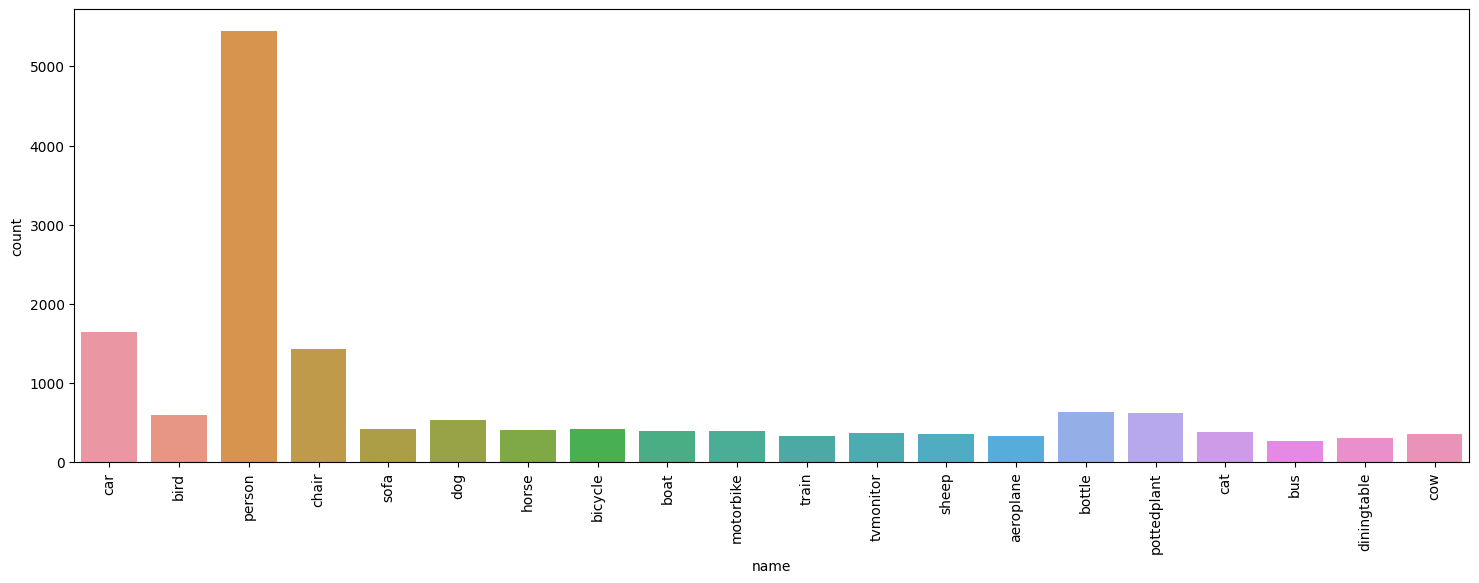

In [20]:
plt.figure(figsize=(18, 6), dpi=100)
sns.countplot(data=df, x='name')
plt.xticks(rotation=90)
plt.show()

### Preparing our label_data for YOLO

In [21]:
df_updated = df.copy()
df_updated['width'] = df_updated['width'].astype("int64")
df_updated['height'] = df_updated['height'].astype("int64")
df_updated['xmin'] = df_updated['xmin'].astype("int64")
df_updated['xmax'] = df_updated['xmax'].astype("int64")
df_updated['ymin'] = df_updated['ymin'].astype("int64")
df_updated['ymax'] = df_updated['ymax'].astype("int64")
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15663 entries, 0 to 15662
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  15663 non-null  object
 1   width     15663 non-null  int64 
 2   height    15663 non-null  int64 
 3   name      15663 non-null  object
 4   xmin      15663 non-null  int64 
 5   xmax      15663 non-null  int64 
 6   ymin      15663 non-null  int64 
 7   ymax      15663 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 979.1+ KB


In [22]:
df_updated['center_x'] = np.round((df_updated['xmin'] + df_updated['xmax'] / 2) / df_updated['width'], 3)
df_updated['center_y'] = np.round((df_updated['ymin'] + df_updated['ymax'] / 2) / df_updated['height'], 3)
df_updated['width_norm'] = np.round((df_updated['xmax'] - df_updated['xmin']) / df_updated['width'], 3)
df_updated['height_norm'] = np.round((df_updated['ymax'] - df_updated['ymin']) / df_updated['height'], 3)

In [23]:
#required labelling for YOLO -- Normalization of data as well
df_updated.head()

,filename,width,height,name,xmin,xmax,ymin,ymax,center_x,center_y,width_norm,height_norm
0,000590.jpg,500,337,car,199,500,109,336,0.898,0.822,0.602,0.674
1,009598.jpg,500,375,bird,160,246,157,358,0.566,0.896,0.172,0.536
2,009598.jpg,500,375,bird,199,413,135,302,0.811,0.763,0.428,0.445
3,004859.jpg,375,500,person,136,209,171,270,0.641,0.612,0.195,0.198
4,004859.jpg,375,500,person,57,177,205,390,0.388,0.800,0.320,0.370


### Split data intro train and test

In [24]:
# Total number of images that we have

images = df['filename'].unique()
len(images)

5012

In [25]:
# Splitting in to 80%:20% percent ratios with random shuffle
img_df = pd.DataFrame(images, columns=['filename'])
img_train = tuple(img_df.sample(frac=0.8)['filename'])
img_test = tuple(img_df.query(f'filename not in {img_train}')['filename'])

In [26]:
train_df = df_updated.query(f"filename in {img_train}")
test_df = df_updated.query(f"filename in {img_test}")

In [27]:
train_df.head()

,filename,width,height,name,xmin,xmax,ymin,ymax,center_x,center_y,width_norm,height_norm
0,000590.jpg,500,337,car,199,500,109,336,0.898,0.822,0.602,0.674
1,009598.jpg,500,375,bird,160,246,157,358,0.566,0.896,0.172,0.536
2,009598.jpg,500,375,bird,199,413,135,302,0.811,0.763,0.428,0.445
3,004859.jpg,375,500,person,136,209,171,270,0.641,0.612,0.195,0.198
4,004859.jpg,375,500,person,57,177,205,390,0.388,0.800,0.320,0.370


### Performing Label Coding

In [28]:
train_df['name_id'] = LabelEncoder().fit_transform(train_df['name'])
test_df['name_id'] = LabelEncoder().fit_transform(test_df['name'])

<ipython-input-28-9755c1894a4f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['name_id'] = LabelEncoder().fit_transform(train_df['name'])
<ipython-input-28-9755c1894a4f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['name_id'] = LabelEncoder().fit_transform(test_df['name'])


In [29]:
#Successfully assign number id to names
test_df

,filename,width,height,name,xmin,xmax,ymin,ymax,center_x,center_y,width_norm,height_norm,name_id
17,006599.jpg,500,375,chair,100,248,1,209,0.448,0.281,0.296,0.555,8
18,006599.jpg,500,375,chair,309,386,10,217,1.004,0.316,0.154,0.552,8
19,006599.jpg,500,375,person,37,158,1,262,0.232,0.352,0.242,0.696,14
20,006599.jpg,500,375,person,224,500,1,375,0.948,0.503,0.552,0.997,14
35,002994.jpg,500,375,car,164,309,280,338,0.637,1.197,0.290,0.155,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15649,001492.jpg,500,334,car,185,487,168,316,0.857,0.976,0.604,0.443,6
15650,001492.jpg,500,334,car,45,104,157,187,0.194,0.750,0.118,0.090,6
15651,001492.jpg,500,334,car,1,43,158,189,0.045,0.756,0.084,0.093,6
15652,001492.jpg,500,334,car,394,419,130,147,1.207,0.609,0.050,0.051,6


### Moving all Images in 'Train and 'Test Folder

In [30]:
train_folder = 'data_images/train'
test_folder = 'data_images/test'

os.mkdir(train_folder)
os.mkdir(test_folder)

In [31]:
cols = ['filename', 'name_id', 'center_x',	'center_y',	'width_norm',	'height_norm']
groupby_obj_train = train_df[cols].groupby('filename')
groupby_obj_test = test_df[cols].groupby('filename')

In [32]:
groupby_obj_test.get_group('002513.jpg').set_index('filename').to_csv('sample.txt', index=False, header=False)

In [33]:
def save_data(filename, folder_path, group_obj):
  src = os.path.join('data_images', filename)
  dst = os.path.join(folder_path, filename)
  move(src, dst)

  text_filename = os.path.join(folder_path, os.path.splitext(filename)[0] + '.txt')
  group_obj.get_group(filename).set_index('filename').to_csv(text_filename, sep=' ', index=False, header=False)

In [34]:
filename_series = pd.Series(groupby_obj_train.groups.keys())
filename_series.apply(save_data, args=(train_folder, groupby_obj_train))

0       None
1       None
2       None
3       None
4       None
        ... 
4005    None
4006    None
4007    None
4008    None
4009    None
Length: 4010, dtype: object

In [35]:
filename_series_test = pd.Series(groupby_obj_test.groups.keys())
filename_series_test.apply(save_data, args=(test_folder, groupby_obj_test))

0       None
1       None
2       None
3       None
4       None
        ... 
997     None
998     None
999     None
1000    None
1001    None
Length: 1002, dtype: object

In [36]:
for i in os.listdir('data_images'):
  if os.path.splitext(i)[1] == '.xml':
    path = 'data_images/' + i
    os.remove(path)

### Importing Yolo_V5

In [37]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 14384, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14384 (delta 4), reused 8 (delta 1), pack-reused 14371
Receiving objects: 100% (14384/14384), 13.61 MiB | 9.49 MiB/s, done.
Resolving deltas: 100% (9898/9898), done.


In [38]:
os.chdir('/content/yolov5')

In [39]:
!ls

benchmarks.py	 data	     LICENSE	       segment	       utils
CITATION.cff	 detect.py   models	       setup.cfg       val.py
classify	 export.py   README.md	       train.py
CONTRIBUTING.md  hubconf.py  requirements.txt  tutorial.ipynb


In [40]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 9.9 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 1.6 MB 60.2 MB/s 


### Training YOLO V5 Model

Training initally only 10 epochs

In [47]:
!python train.py --data data.yaml --weights yolov5x.pt --batch-size 16 --name Model --img 640 --epochs 15

train: weights=yolov5x.pt, cfg=, data=data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=15, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=Model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-27-g454dae1 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, d

**Will resume trainig from where we stop ... Our train model is avaialble in 'runs/train/Model6'**